In [36]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn

iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=1./3, random_state=1)

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)
train_ds = TensorDataset(X_train_norm, y_train)

In [37]:
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [38]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x
    
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
model = Model(input_size, hidden_size, output_size)

In [39]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
num_epochs = 100
loss_history = [0]*num_epochs
accuracy_history = [0]*num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

        loss_history[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(y_pred, dim=1) == y_batch).float()
        accuracy_history[epoch] += is_correct.mean()
    loss_history[epoch] /= len(train_dl.dataset)
    accuracy_history[epoch] /= len(train_dl.dataset)


print(loss_history)

[1.106467490196228, 1.0991894817352295, 1.0918877553939819, 1.0839923667907714, 1.0766591358184814, 1.066903865337372, 1.0561577916145324, 1.0434854984283448, 1.028944115638733, 1.0132972240447997, 0.9947829580307007, 0.9754086458683013, 0.9561121845245362, 0.9368114817142487, 0.9193408906459808, 0.9040364623069763, 0.8906673872470856, 0.8794972956180572, 0.8694274377822876, 0.8610549509525299, 0.8542694616317749, 0.8470267343521118, 0.8418801546096801, 0.8355431437492371, 0.8307463026046753, 0.825468590259552, 0.8202253222465515, 0.8156181478500366, 0.8113576602935791, 0.8060189723968506, 0.8019679033756256, 0.7957944571971893, 0.7916240096092224, 0.7862218940258026, 0.7816057622432708, 0.7769893109798431, 0.7727372837066651, 0.7676339054107666, 0.7628274941444397, 0.758383219242096, 0.7553278136253357, 0.7508695805072785, 0.745363290309906, 0.7420202648639679, 0.7387937355041504, 0.7343796169757844, 0.7301822745800018, 0.7265428626537322, 0.7231117987632751, 0.7200850987434387, 0.719

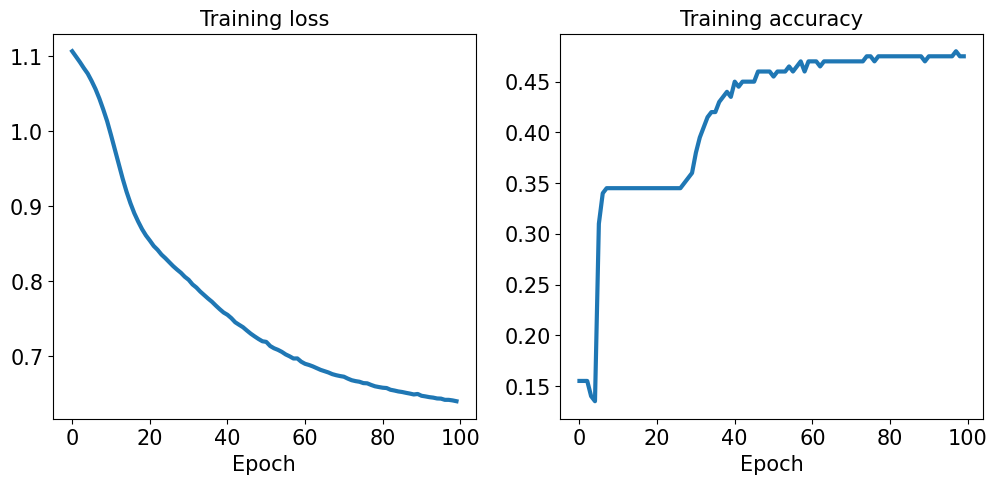

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_history, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_history, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [42]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [43]:
path = 'iris/iris_classifier.pt'
torch.save(model, path)

In [44]:
model_new = torch.load(path)

In [45]:
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [46]:
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Eval accuracy : {accuracy}')

Eval accuracy : 0.9800000190734863


In [47]:
path = 'iris/iris_classifie_state.pt'
torch.save(model.state_dict(), path)

In [48]:
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>